#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [1]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=22b8a0bd-610a-49cb-9e3f-bf406d0fba51
To: /home/jupyter/NX414-Project/week5/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 116MB/s]  


'IT_data.h5'

### Load the data

In [2]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [3]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


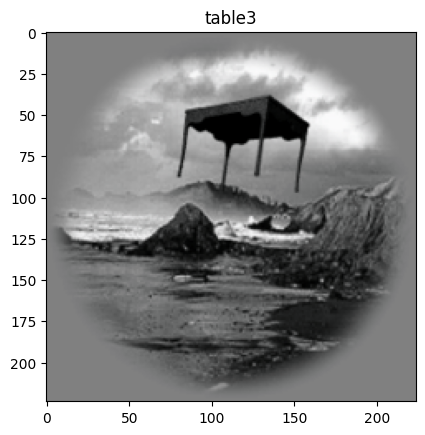

In [4]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

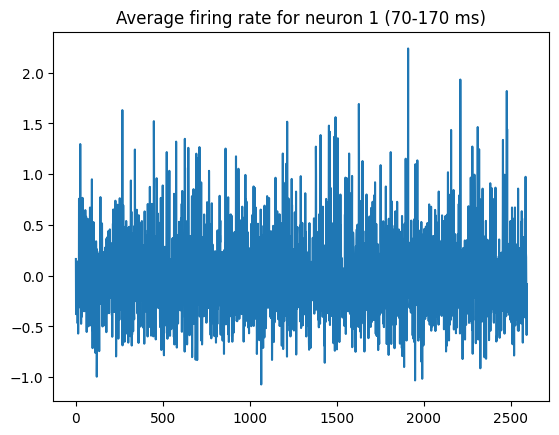

In [5]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [6]:
#### Here your code
from sklearn.linear_model import LinearRegression
X=stimulus_train.reshape(2592,3*224*224)
reg = LinearRegression().fit(X, spikes_train)

In [7]:
#Ridge regression 
from sklearn.linear_model import Ridge
ridge_reg= Ridge(alpha=1).fit(X,spikes_train) #For the moment we keep the default parameter for alpha

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.7811e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [8]:
from sklearn.metrics import explained_variance_score

def evaluate_fitted_model(pred):
    '''
    Takes the predictions given for the spikes for the validation set images and outputs the correlations 
    and explained variances with the true spikes for each image of this set.
    '''
    correlations=[]
    explained_var=[]
    #We calculate the correlations and the explained variance for each image
    for i in range(168):
        correlations.append(np.corrcoef(pred[:,i],spikes_val[:,i])[0,1])
        explained_var.append(explained_variance_score(spikes_val[:,i],pred[:,i]))
    return(correlations,explained_var)

correlations, explained_var=evaluate_fitted_model(reg.predict(stimulus_val.reshape(288,3*224*224)))
ridge_correlations, ridge_explained_var=evaluate_fitted_model(ridge_reg.predict(stimulus_val.reshape(288,3*224*224)))


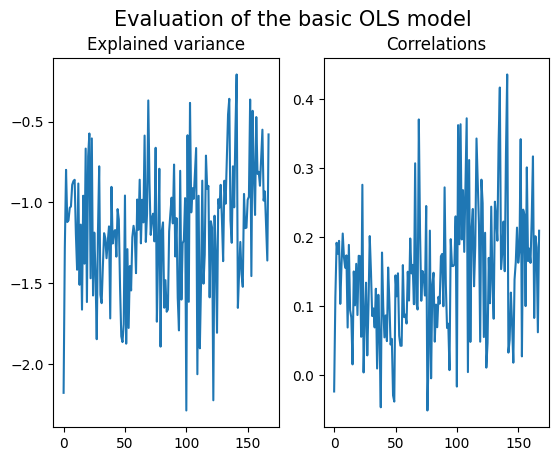

In [9]:
fig, (ax1,ax2)=plt.subplots(1,2)
fig.suptitle('Evaluation of the basic OLS model', fontsize=15)
ax1.plot(explained_var)
ax1.set_title('Explained variance')
ax2.plot(correlations)
ax2.set_title('Correlations')
plt.show()


In order to limit the risk of over-fitting the data, let's try also a ridge regression model:

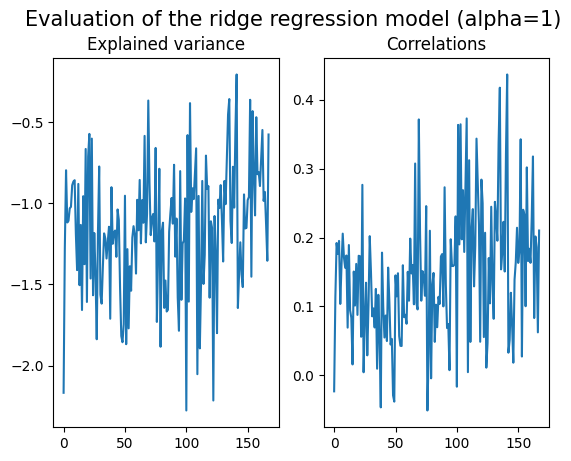

In [10]:
fig, (ax1,ax2)=plt.subplots(1,2)
fig.suptitle('Evaluation of the ridge regression model (alpha=1)', fontsize=15)
ax1.plot(ridge_explained_var)
ax1.set_title('Explained variance')
ax2.plot(ridge_correlations)
ax2.set_title('Correlations')
plt.show()

One can immediatly note that all these are very poor results. In particular, the fact that we obtain negative values for the explained variance means that our model add variability to the original data instead of explaining part of it!

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [11]:
#Fitting the PCA parameters on the training stimulus
from sklearn.decomposition import PCA
pca=PCA(n_components=1000)
pca.fit(X)

PCA(n_components=1000)

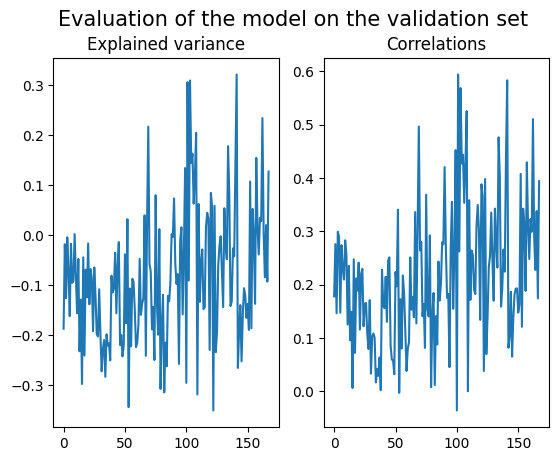

In [12]:
#Performing a Ridge regression on these 1000 PCs
ridge_reg2 = Ridge(alpha=1).fit(pca.transform(X), spikes_train)
pred=ridge_reg2.predict(pca.transform(stimulus_val.reshape(288,3*224*224)))
correlations,explained_var=evaluate_fitted_model(pred)

fig, (ax1,ax2)=plt.subplots(1,2)
fig.suptitle('Evaluation of the model on the validation set', fontsize=15)
ax1.plot(explained_var)
ax1.set_title('Explained variance')
ax2.plot(correlations)
ax2.set_title('Correlations')
plt.show()

We can note a significant improvement, both on correlations and explained variance. However, the results are still very disappointing, the explained variance being negative in many cases.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#We try several possible values for the parameter alpha
alphas=[0.01,0.1,1,5,10]

#We store the results
correlations= [[] for _ in range(len(alphas))]
explained_variances=[[] for _ in range(len(alphas))]

for i in range(len(alphas)):
    #Create a ridge model
    rr=Ridge(alpha=alphas[i])
    # Create StratifiedKFold object to perfrom a 5-fold cross validation keeping balanced distributions of classes
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  
    for train_index, test_index in skf.split(X, objects_train):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = spikes_train[train_index], spikes_train[test_index]
        pca=PCA(n_components=1000)
        pca.fit(x_train_fold)
        rr.fit(pca.transform(x_train_fold),y_train_fold)
        corr,exp_var=evaluate_fitted_model(rr.predict(pca.transform(stimulus_val.reshape(288,3*224*224))))
        correlations[i].append(np.mean(corr))
        explained_variances[i].append(np.mean(exp_var))



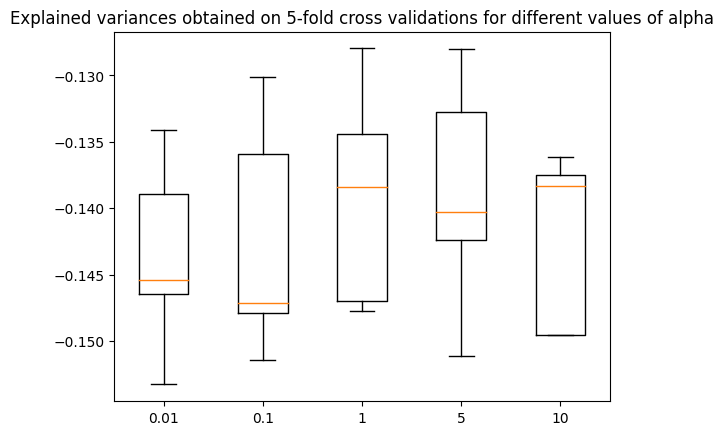

In [14]:
#Plotting the results as boxplots since we performed 5-fold cross validation for each value of alpha
#Explained variances
plt.boxplot(explained_variances,labels=alphas)
plt.title('Explained variances obtained on 5-fold cross validations for different values of alpha')
plt.show()

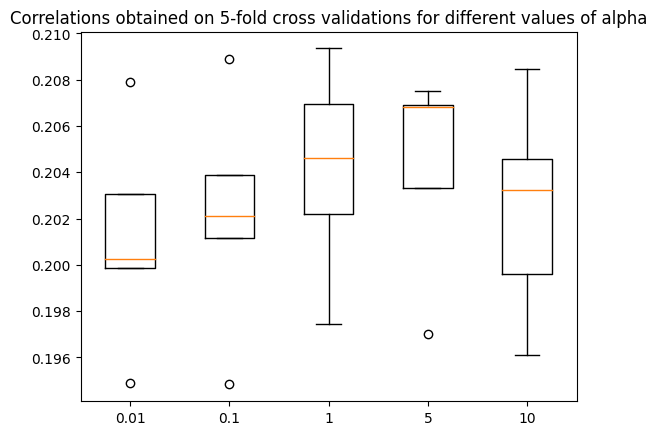

In [15]:
#Correlations
plt.boxplot(correlations,labels=alphas)
plt.title('Correlations obtained on 5-fold cross validations for different values of alpha')
plt.show()

Based on these results, we can say that no particular value for alpha, among the range [0.01,0.1,1,5,10], outperformed the other ones. Thus, the parameter can be set at its default value which is 1. Then the models we tried based on pixels data did not allow to reach a satisfactory level of explained IT cortex variance.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [16]:
#Useful importations
from torchvision.models.resnet import model_urls
import torch
import torchvision
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Dict, Optional, cast
from torch import Tensor
from collections import OrderedDict 
from torchvision.models.resnet import *
from torchvision.models.resnet import BasicBlock, Bottleneck

Let's create our own class that inherits from ResNet but that will output the values given by the layer we want. 
Doing so, we will have access to the activations in any layer. 

In [17]:
class IntResNet(ResNet):
    def __init__(self,output_layer,*args):
        self.output_layer = output_layer
        super().__init__(*args)
        
        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def new_resnet(arch: str, outlayer: str, block: Type[Union[BasicBlock, Bottleneck]], layers: List[int], pretrained: bool, progress: bool,**kwargs: Any) -> IntResNet:
  model = IntResNet(outlayer, block, layers, **kwargs)
  if pretrained:
      state_dict = load_state_dict_from_url(model_urls[arch],
                                            progress=progress)
      model.load_state_dict(state_dict)
  return model

We now convert our stimuli into tensors:

In [18]:
stimulus_train_torch=torch.from_numpy(stimulus_train)
stimulus_val_torch=torch.from_numpy(stimulus_val)

Now, for each layer, we are going to collect the the 1000 principal components of the activations triggered by the images from the training and validation sets. 

In [19]:
%%capture --no-display
layers=['conv1','layer1','layer2','layer3','layer4','avgpool']
PCA_trains=[]
PCA_validations=[]
pca_models=[]

for i in range(len(layers)):

    #We define a new ResNet50 model that will output the activations of layers[i]
    model = new_resnet('resnet50',layers[i],Bottleneck, [3, 4, 6, 3],True,True)
    model.eval()
    output_size=model(torch.unsqueeze(stimulus_train_torch[0],0)).detach().numpy().flatten().shape[0] 
    activations=np.zeros((stimulus_train_torch.shape[0],output_size),dtype=np.float32)#An array of size #training_images x #output_coefficients
    for j in range(stimulus_train_torch.shape[0]):
        batch=torch.unsqueeze(stimulus_train_torch[j],0)
        out=model(batch).detach().numpy().squeeze()
        activations[j,:]=out.flatten()

    #Then we fit a PCA model on this matrix of activations
    pca=PCA(n_components=1000)
    pca.fit(activations)
    pca_models.append(pca)
    PCA_trains.append(pca.transform(activations))
    
    activations=np.zeros((stimulus_val_torch.shape[0],output_size),dtype=np.float32)
    for j in range(stimulus_val_torch.shape[0]):
        batch=torch.unsqueeze(stimulus_val_torch[j],0)
        out=model(batch).detach().numpy().squeeze()
        activations[j,:]=out.flatten()
    PCA_validations.append(pca.transform(activations))
    


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We can now train a linear model to make predictions for the spikes from these PCs extracted from the different layers. We chose to use a ridge regression model with default parameter alpha=1.

In [20]:
alpha=1
correlations= []
explained_variances=[]
for i in range(len(PCA_trains)):
    #Training a ridge_regression model on the PCs of the activations in layer[i]
    ridge_reg = Ridge(alpha=alpha).fit(PCA_trains[i], spikes_train)
    #Predictions for the validation set
    pred=ridge_reg.predict(PCA_validations[i])
    corr,exp_var=evaluate_fitted_model(pred)
    correlations.append(corr)
    explained_variances.append(exp_var)

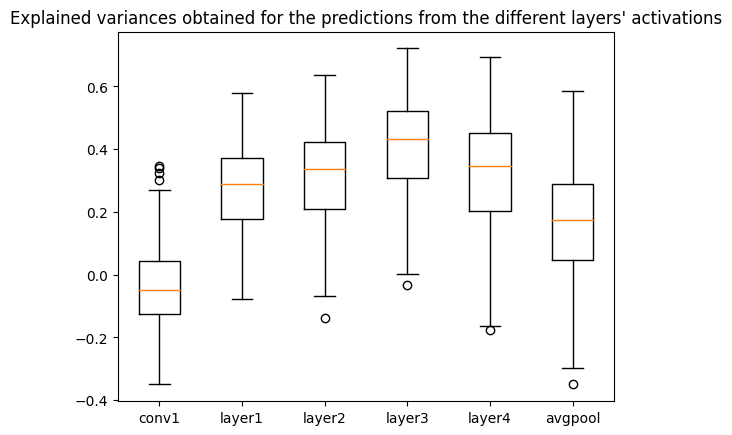

In [21]:
#Plotting the results as boxplots for every layer
#Explained variances
plt.boxplot(explained_variances,labels=layers)
plt.title("Explained variances obtained for the predictions from the different layers' activations")
plt.show()

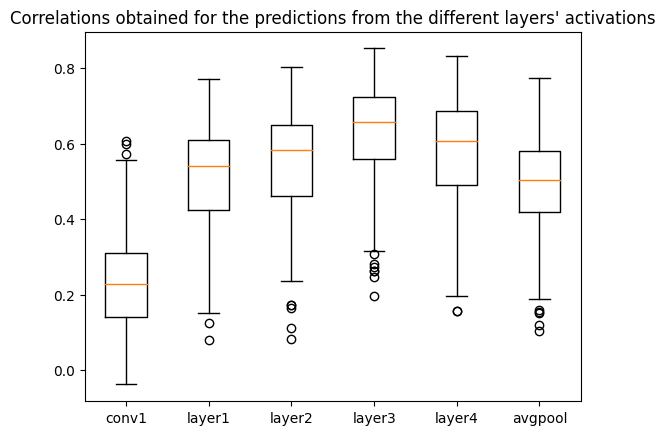

In [22]:
#Plotting the results as boxplots for every layer
#Correlations
plt.boxplot(correlations,labels=layers)
plt.title("Correlations obtained for the predictions from the different layers' activations")
plt.show()

Now, let's comapre those results to the ones we could have obtained with a non-pretrained (randomly intialized) network. For that purpose, we will comapre the results we obtain in both cases for Layer 3, the one that gave the best median correlations and explained variance in the pre-trained model.

To do so, we will train a ridge regression model, with the same parameter alpha as before, on the principal components of the activations of Layer 3 in the randomly initialized layer.

In [23]:
%%capture --no-display

layer='layer3'
#We define a new ResNet50 model that will output the activations of Layer 3
model = new_resnet('resnet50','layer3',Bottleneck, [3, 4, 6, 3],pretrained=False,progress=True) #We use a non-pretrained netwotk
model.eval()
output_size=model(torch.unsqueeze(stimulus_train_torch[0],0)).detach().numpy().flatten().shape[0]
activations=np.zeros((stimulus_train_torch.shape[0],output_size),dtype=np.float32)
for j in range(stimulus_train_torch.shape[0]):
    batch=torch.unsqueeze(stimulus_train_torch[j],0)
    out=model(batch).detach().numpy().squeeze()
    activations[j,:]=out.flatten()

#Then we fit a PCA model on this matrix of activations
pca=PCA(n_components=1000)
pca.fit(activations)
PCA_training_random_network=pca.transform(activations)

activations=np.zeros((stimulus_val_torch.shape[0],output_size),dtype=np.float32)
for j in range(stimulus_val_torch.shape[0]):
    batch=torch.unsqueeze(stimulus_val_torch[j],0)
    out=model(batch).detach().numpy().squeeze()
    activations[j,:]=out.flatten()
PCA_validations_random_network=pca.transform(activations)


#Training a ridge_regression model with the same parameter alpha as before on these PCs
ridge_reg = Ridge(alpha=alpha).fit(PCA_training_random_network, spikes_train)
#Predictions for the validation set
pred=ridge_reg.predict(PCA_validations_random_network)
corr_random,exp_var_random=evaluate_fitted_model(pred)


Let's visualize the results:

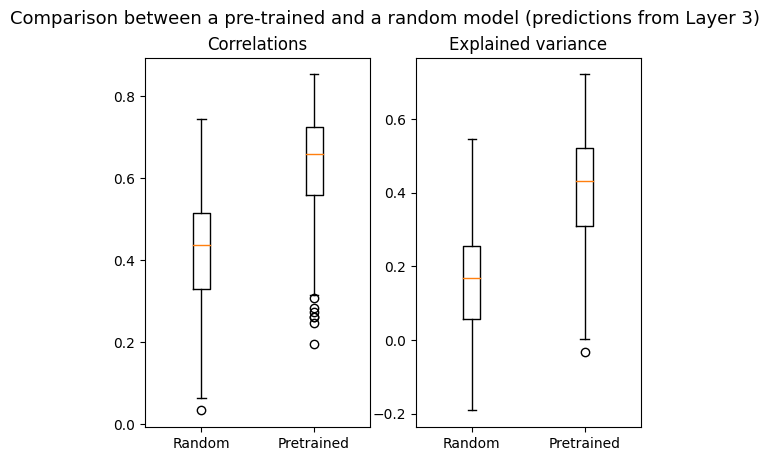

In [24]:
fig, (ax1,ax2)=plt.subplots(1,2)
fig.suptitle('Comparison between a pre-trained and a random model (predictions from Layer 3)', fontsize=13)
ax1.boxplot([corr_random,correlations[3]],labels=['Random','Pretrained'])
ax1.set_title('Correlations')
ax2.boxplot([exp_var_random,explained_variances[3]],labels=['Random','Pretrained'])
ax2.set_title('Explained variance')
plt.show()


Interestingly, the naive model performs quite well, in particular it performs much better than the pixels-based models. This is consistent with the results from **Martin Schrimpf et al. (2021)**. They showed, in the case of language areas, that training an artifical model could only improve its performances by around 50%. It highlights the importance of the artchitecture of the network in itself and, in a way, the relative importance of evolution as opposed to learning-based optimization. 


In [25]:
relative_increase=(np.mean(explained_variances[3])-np.mean(exp_var_random))/np.mean(exp_var_random)
print("Training increases the results by ", round((relative_increase-1)*100,1),"%" )

Training increases the results by  48.6 %


Indeed, based on the mean explained variance, we see that in our case the use of a pretrained model allowed a 80% increase in terms of variance explanation. 

**The best model we found if then based on the 1000 principal components of the activations of Layer 3.**